<a href="https://colab.research.google.com/github/Arijit-datascience/Neural_network_backpropagation/blob/main/MNIST_digit_recognition_Session_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# Reading MNIST data

In [5]:
train_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))

test_data = datasets.MNIST('../data', train=False, download=True,
                    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
n_train = len(train_data)
n_test = len(test_data)

print('Number of training samples: {0}'.format(n_train))
print('Number of test samples: {0}'.format(n_test))

Number of training samples: 60000
Number of test samples: 10000


# Model Architecture

In [162]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=7, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.03),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.03)
        )

        self.classifier = nn.Sequential(
            nn.Linear(32, 10)
        )

    def forward(self, x):
      x = self.features(x)
      x = F.adaptive_max_pool2d(x, (1, 1))
      x = x.view(x.size(0), -1)
      x = self.classifier(x)
      x = F.log_softmax(x, dim=1)
      return x

# Model Summary

In [163]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]             800
       BatchNorm2d-2           [-1, 16, 24, 24]              32
              ReLU-3           [-1, 16, 24, 24]               0
         MaxPool2d-4           [-1, 16, 12, 12]               0
            Conv2d-5           [-1, 32, 12, 12]           4,640
       BatchNorm2d-6           [-1, 32, 12, 12]              64
              ReLU-7           [-1, 32, 12, 12]               0
         MaxPool2d-8             [-1, 32, 6, 6]               0
           Dropout-9             [-1, 32, 6, 6]               0
           Conv2d-10             [-1, 32, 6, 6]           9,248
      BatchNorm2d-11             [-1, 32, 6, 6]              64
             ReLU-12             [-1, 32, 6, 6]               0
          Dropout-13             [-1, 32, 6, 6]               0
           Linear-14                   

# Model

In [164]:
model.eval()

Net(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.03, inplace=False)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Dropout(p=0.03, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=10, bias=True)
  )
)

# Data Loading ...

In [165]:
torch.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=True, **kwargs)

# Train Loop

In [166]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    if epoch > 1:
        exp_lr_scheduler.step()
    epoch_loss = 0
    correct = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    print(f'Train set: Average loss: {loss.item():.4f}, Accuracy: {100. * correct/len(train_loader.dataset):.2f}')
    train_loss = epoch_loss / len(train_loader)
    return train_loss

# Test Loop

In [167]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.3f}, Accuracy: {100. * correct/len(test_loader.dataset):.2f}')
    return test_loss

# Defining optimizer and learning rate scheduler

In [168]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0015)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Running the model

In [169]:
train_loss_values = []
test_loss_values = []

for epoch in range(1, 21):
    print('\nEpoch {} : '.format(epoch))
    # train the model
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss = test(model, device, test_loader)

    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)


Epoch 1 : 
Train set: Average loss: 0.0334, Accuracy: 94.91

Test set: Average loss: 0.065, Accuracy: 98.25

Epoch 2 : 
Train set: Average loss: 0.1237, Accuracy: 98.37

Test set: Average loss: 0.037, Accuracy: 98.91

Epoch 3 : 
Train set: Average loss: 0.0440, Accuracy: 98.79

Test set: Average loss: 0.038, Accuracy: 98.81

Epoch 4 : 
Train set: Average loss: 0.0108, Accuracy: 99.02

Test set: Average loss: 0.029, Accuracy: 99.03

Epoch 5 : 
Train set: Average loss: 0.0321, Accuracy: 99.14

Test set: Average loss: 0.026, Accuracy: 99.15

Epoch 6 : 
Train set: Average loss: 0.0004, Accuracy: 99.21

Test set: Average loss: 0.030, Accuracy: 98.94

Epoch 7 : 
Train set: Average loss: 0.0782, Accuracy: 99.31

Test set: Average loss: 0.027, Accuracy: 99.16

Epoch 8 : 
Train set: Average loss: 0.0270, Accuracy: 99.69

Test set: Average loss: 0.021, Accuracy: 99.26

Epoch 9 : 
Train set: Average loss: 0.0019, Accuracy: 99.77

Test set: Average loss: 0.020, Accuracy: 99.34

Epoch 10 : 
Train 

# Plotting the train and test loss across each epoch

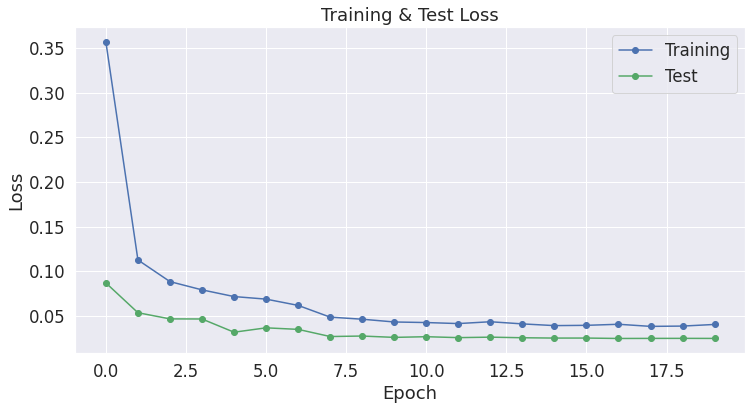

In [50]:
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(np.array(train_loss_values), 'b-o', label="Training")
plt.plot(np.array(test_loss_values), 'g-o', label="Test")


# Label the plot.
plt.title("Training & Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Average Test Loss

In [ ]:
print(f'Average test loss: {test_loss:.3f}')

Average test loss: 0.018
